In [34]:
%env TF_GPU_ALLOCATOR=cuda_malloc_async
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Nadam



env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [35]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anandkumarsahu09/cattle-breeds-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/user/.cache/kagglehub/datasets/anandkumarsahu09/cattle-breeds-dataset/versions/1


In [36]:
img_size = (1024, 1024)
batch_size = 2
print(os.listdir(path))
dataset_path = os.path.join(path, "Cattle Breeds")
print(os.listdir(dataset_path))
classes = os.listdir(dataset_path)
num_classes = len(classes)

['Cattle Breeds']
['Red Dane cattle', 'Ayrshire cattle', 'Jersey cattle', 'Brown Swiss cattle', 'Holstein Friesian cattle']


In [37]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.7,1.3],
    horizontal_flip=True,
    validation_split=0.2 # 20% for validation
)

train_data = datagen.flow_from_directory(
    dataset_path,
    classes=classes,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode='rgb'
)

val_data = datagen.flow_from_directory(
    dataset_path,
    classes=classes,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb'
)


Found 969 images belonging to 5 classes.
Found 239 images belonging to 5 classes.


In [38]:
print("Train data shape:", train_data.image_shape)
print("Val data shape:", val_data.image_shape)


Train data shape: (1024, 1024, 3)
Val data shape: (1024, 1024, 3)


In [39]:
print("Classes:", train_data.class_indices)   # mapping of breed → index
print("Train samples:", train_data.samples)
print("Validation samples:", val_data.samples)


Classes: {'Red Dane cattle': 0, 'Ayrshire cattle': 1, 'Jersey cattle': 2, 'Brown Swiss cattle': 3, 'Holstein Friesian cattle': 4}
Train samples: 969
Validation samples: 239


In [40]:
base_model = ResNet50V2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(img_size[0], img_size[1], 3)
)

model = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.6),
    layers.Dense(num_classes, activation="softmax")
])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 32, 32, 2048)   │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 2048)   │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 2048)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,583,237 (89.96 MB)

 Trainable params: 23,533,701 (89.77 MB)

 Non-trainable params: 49,536 (193.50 KB)

In [41]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Nadam(1e-4),
    metrics=['accuracy']
)

# #Recomplile the model
# base_model.trainable = True
# for layer in base_model.layers[:-50]:
#     layer.trainable = False
# model.compile(
#     loss='categorical_crossentropy',
#     optimizer=Nadam(1e-4),
#     metrics=['accuracy']
# )

In [ ]:
# 5. Train the Model

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',      # monitor validation loss
    patience=5,              # stop if no improvement for 5 epochs
    restore_best_weights=True, # restore weights from best epoch
    verbose=1
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,              # set a high number; EarlyStopping will stop automatically
    callbacks=[early_stop]
)


Epoch 1/10
377/485 ━━━━━━━━━━━━━━━━━━━━ 36s 335ms/step - accuracy: 0.2926 - loss: 1.6213

2025-09-29 20:48:22.434902: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-29 20:48:22.556035: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-29 20:48:24.165420: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:361] gpu_async_0 cuMemAllocAsync failed to allocate 8742043648 bytes: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
 Reported by CUDA: Free memory/Total memory: 1451032576/3948675072
2025-09-29 20:48:24.165435: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:366] Stats: Limit:                      1970929664
InUse:                       708291568
MaxInUse:                   3

485/485 ━━━━━━━━━━━━━━━━━━━━ 241s 446ms/step - accuracy: 0.3901 - loss: 1.4762 - val_accuracy: 0.6025 - val_loss: 1.1743
Epoch 2/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 194s 399ms/step - accuracy: 0.5129 - loss: 1.2607 - val_accuracy: 0.5523 - val_loss: 1.5095
Epoch 3/10
244/485 ━━━━━━━━━━━━━━━━━━━━ 1:20 335ms/step - accuracy: 0.4994 - loss: 1.2035

In [ ]:
        # 6. Evaluate on Test Set
loss, acc = model.evaluate(val_data)
print(f"Test Accuracy: {acc*100:.2f}%")


95/95 ━━━━━━━━━━━━━━━━━━━━ 27s 279ms/step - accuracy: 0.7263 - loss: 0.8246
Test Accuracy: 72.63%


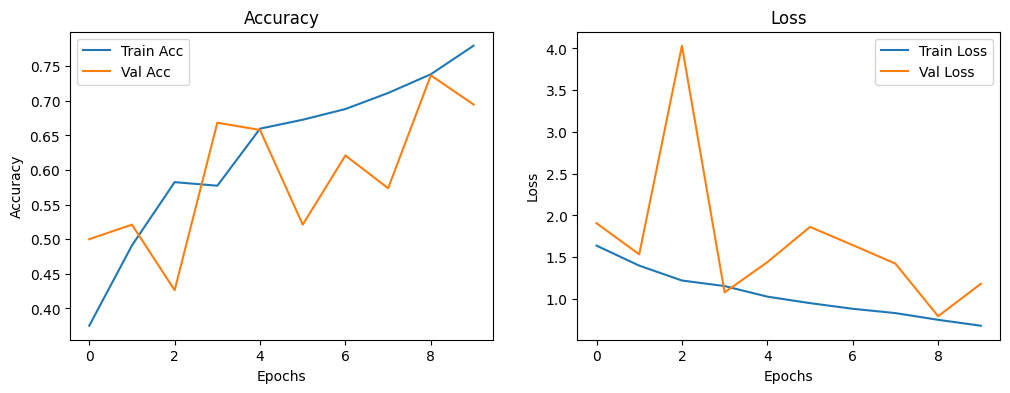

In [ ]:
# 7. Training Curves (Accuracy & Loss)
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


95/95 ━━━━━━━━━━━━━━━━━━━━ 28s 277ms/step


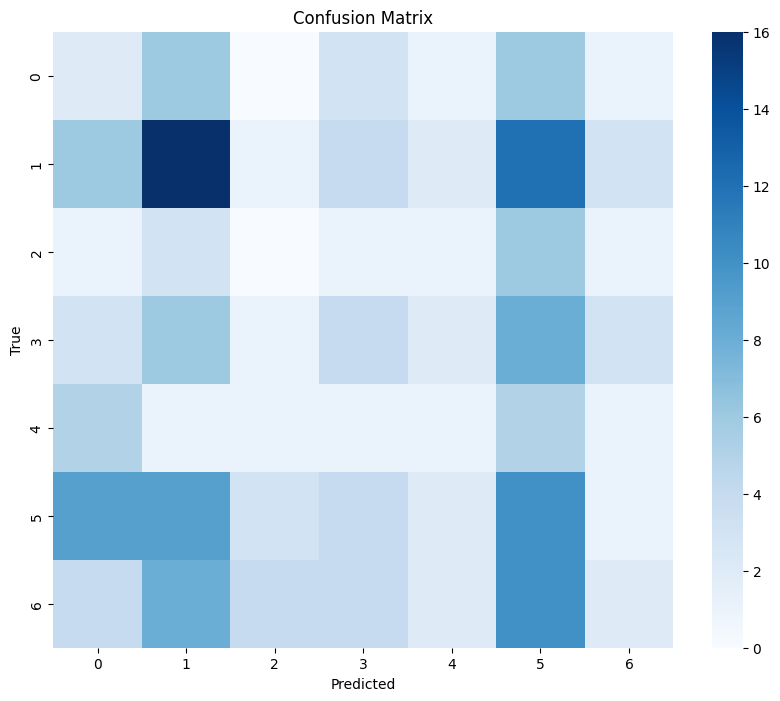

              precision    recall  f1-score   support

       dhani       0.07      0.11      0.08        19
  cholistani       0.33      0.36      0.34        44
     fresian       0.00      0.00      0.00        13
       sibbi       0.19      0.15      0.17        27
    kankarej       0.09      0.07      0.08        15
     brahman       0.18      0.26      0.21        38
     sahiwal       0.17      0.06      0.09        34

    accuracy                           0.18       190
   macro avg       0.15      0.14      0.14       190
weighted avg       0.18      0.18      0.18       190



In [ ]:
# 8. Confusion Matrix & Classification Report
y_true = val_data.classes
y_pred = np.argmax(model.predict(val_data), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=list(val_data.class_indices.keys())))
